# Cal-CRAI Index: Society & Economy Domain

**Order of operations**:
- Metric handling
   - Retrieve data
   - Outlier handling
   - Min-max standardization
   - Set vulnerability orientation (pos for vulnerable, neg for resilience)
- Calculate indicators
   - Min-max standardization
- Calculate domain score
- Visualizations

Note: Functions and figures within this notebook are in development

In [1]:
import pandas as pd
import os
import sys

# suppress pandas purely educational warnings
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

sys.path.append(os.path.expanduser('../../'))
from scripts.utils.file_helpers import pull_csv_from_directory, upload_csv_aws
from scripts.utils.write_metadata import append_metadata
from scripts.utils.index_plot import plot_domain, plot_region_domain
from scripts.utils.calculate_index import (handle_outliers, min_max_standardize, process_domain_csv_files, 
                                        compute_averaged_indicators, compute_summed_indicators, indicator_dicts, 
                                        add_census_tracts, domain_summary_stats)

## Step 1: Metric level
### 1a) Retrieve metric files and process

In [2]:
# set-up
bucket_name = 'ca-climate-index'
aws_dir = '3_fair_data/index_data/'

# metric tracking -- change to your local version (to do: add public facing version)
meta_csv = r'/Users/victoriaford/Desktop/carb-climate-index/scripts/utils/Full Data Pipeline Notes - 4_ Calculate Metric.csv'

# domain-specific
domain_prefix = 'society_'  # You can change this to any prefix you need
output_folder = domain_prefix + "folder"

In [3]:
# retrieve data from AWS
pull_csv_from_directory(bucket_name, aws_dir, search_zipped=False, print_name=False)
merged_output_file = 'concatenate_society_economy_metrics.csv'
process_domain_csv_files(domain_prefix, output_folder, meta_csv, merged_output_file)

Metric data retrieved from 3_fair_data/index_data/.
Processed and saved 33 CSV files.
Deleted 68 local non-relevant CSV files.

All entries within the island tract (6075980401) are NaN.

Number of infinite entries in the DataFrame: 67
Replacing infinite entries (if any) with NaN
Number of infinite entries in the DataFrame: 0

File processing complete, dataframe will now be saved as a .csv
Processed CSV saved as concatenate_society_economy_metrics.csv


In [4]:
# read-in and view processed data
processed_society_df = pd.read_csv('concatenate_society_economy_metrics.csv')
processed_society_df

,GEOID,health and personal care stores per 10000 people_resilient,poverty_percent_2019_vulnerable,hospitals per 10000 people_resilient,percent_population_without_health_insurance_vulnerable,linguistic_isolation_percent_2019_vulnerable,avg_hpsscore_primary_care_metric_vulnerable,real_percent_total_pop_over_65_vulnerable,percent_population_cognitive_disabilities_vulnerable,Percent of households without air conditioning_vulnerable,...,hachman_index_vulnerable,percent_1miurban_10mirural_vulnerable,Percent of population employed and aged > 16 working outdoors_vulnerable,est_gini_index_vulnerable,specialty trade contractors per 10000 people_resilient,personal and household goods repair and maintenance per 10000 people_resilient,"Number of Violent Crimes per 10,000 Population_vulnerable",avg_percent_population_homeless_vulnerable,blood and organ banks per 10000 people_resilient,percent_total_pop_american_indian_alaska_native_vulnerable
0,6085504321,2.201550,17.500000,0.083471,3.843311,21.100000,NaN,16.555802,5.210552,35.430875,...,0.788695,27.547393,2.022881,0.4197,11.837246,0.511261,31.703849,0.691595,NaN,0.3
1,6085504410,2.201550,23.100000,0.083471,5.237633,21.100000,NaN,16.197866,3.507880,35.430875,...,0.788695,27.547393,1.144842,0.4309,11.837246,0.511261,31.703849,0.691595,NaN,1.3
2,6085507003,2.201550,17.793413,0.083471,0.260247,11.064134,NaN,26.545218,1.706572,35.430875,...,0.788695,27.547393,4.619098,0.5357,11.837246,0.511261,31.703849,0.691595,NaN,0.0
3,6085507004,2.201550,17.793413,0.083471,0.305655,11.064134,NaN,21.599592,2.310994,35.430875,...,0.788695,27.547393,4.619098,0.4793,11.837246,0.511261,31.703849,0.691595,NaN,0.0
4,6085502204,2.201550,17.793413,0.083471,4.441703,11.064134,NaN,10.579889,9.356358,35.430875,...,0.788695,27.547393,4.619098,0.4010,11.837246,0.511261,31.703849,0.691595,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,6059001303,3.561950,28.300000,0.119676,7.751343,10.200000,NaN,10.744436,4.544180,28.057946,...,0.934257,25.604689,4.455156,0.3590,14.890274,0.834586,25.871294,0.465096,0.050390,0.4
9125,6059001304,3.561950,46.900000,0.119676,19.607293,15.800000,NaN,18.513324,4.226241,28.057946,...,0.934257,25.604689,8.676318,0.3582,14.890274,0.834586,25.871294,0.465096,0.050390,3.9
9126,6059001401,3.561950,37.600000,0.119676,11.480235,13.300000,NaN,16.000841,6.016556,28.057946,...,0.934257,25.604689,6.810978,0.4594,14.890274,0.834586,25.871294,0.465096,0.050390,2.2
9127,6013367200,1.840626,37.100000,0.197824,6.440620,10.500000,NaN,8.843074,3.351287,30.390365,...,0.919995,36.159475,9.026887,0.4130,13.125211,0.498861,42.765917,0.603696,NaN,0.1


### 1b) Outlier handling
Outlier handling is handled according to the process laid out by Baum et al. 1970 [link]. Outliers beyond the max/min fence values are reset to the fence values.
* Max fence = 3 x 75th percentile
* Min fence = -3 x 25th percentile

In [5]:
# handle outliers
no_outlier_society_economy_metrics = handle_outliers(processed_society_df, domain_prefix, summary_stats=False)

Processed and saved no_outlier_society_metrics.csv with outlier handling.


### 1c) Min-max standardization
Metrics are min-max standardized on 0.01 to 0.99 scale.

In [6]:
# standardizing our df
columns_to_process = [col for col in no_outlier_society_economy_metrics.columns if col != 'GEOID']
min_max_metrics = min_max_standardize(no_outlier_society_economy_metrics, columns_to_process)

All standardized columns are within the [0, 1] range (considering tolerance).


Isolate for GEOID and standardized columns exclusively

In [7]:
words = ['GEOID','standardized']
selected_columns = []
for word in words:
    selected_columns.extend(min_max_metrics.columns[min_max_metrics.columns.str.contains(word)].tolist())
min_max_standardized_society_economy_metrics_df = min_max_metrics[selected_columns]

### 1d) Set vulnerability orientation
* High values indicate vulnerability
* Low values indicate resiliency

In [8]:
# Select columns with 'resilient' in their names
resilient_columns = [col for col in min_max_standardized_society_economy_metrics_df.columns if 'resilient' in col]

# Use .loc to ensure modifying the DataFrame correctly
min_max_standardized_society_economy_metrics_df.loc[:, resilient_columns] = 1 - min_max_standardized_society_economy_metrics_df.loc[:, resilient_columns]

## Step 2: Calculate Indicators
Loop to go through df columns and average metrics that belong within an indicator based off of the metric to indicator dictionary

In [9]:
averaged_indicators_society_economy = compute_averaged_indicators(
    min_max_standardized_society_economy_metrics_df, 
    indicator_dicts(domain_prefix[:-1])
)

# show resulting dataframe to highlight the indicator values
averaged_indicators_society_economy

,GEOID,vulnerable_populations,social_services,economic_health
0,6085504321,0.212161,0.840729,0.533783
1,6085504410,0.244947,0.840729,0.580308
2,6085507003,0.190168,0.840729,0.495323
3,6085507004,0.184313,0.840729,0.526713
4,6085502204,0.266563,0.840729,0.671121
...,...,...,...,...
9124,6059001303,0.231278,0.675421,0.678474
9125,6059001304,0.354348,0.675421,0.711943
9126,6059001401,0.289615,0.675421,0.749750
9127,6013367200,0.267410,0.729274,0.701261


Sum all the non-census tract columns together to calculate the domain score

In [10]:
columns_to_sum = [col for col in averaged_indicators_society_economy.columns if col != 'GEOID']
summed_indicators_society_economy = compute_summed_indicators(
    df=averaged_indicators_society_economy, 
    columns_to_sum=columns_to_sum
)

Indicator sum min value: 0.0
Indicator sum max value: 2.2082113292096475


### 2a) Min-max standardize the summed columns

In [11]:
columns_to_process = [col for col in summed_indicators_society_economy.columns if col != 'GEOID']
min_max_domain = min_max_standardize(summed_indicators_society_economy, columns_to_process)

All standardized columns are within the [0, 1] range (considering tolerance).


Isolate to census tract and summed standardized columns, and rename tract to GEOID for merging
* add a zero at the beginning of the GEOID to match census tract that will be merged

In [12]:
min_max_standardized_society_economy_domain = min_max_domain[['GEOID', 'summed_indicators_society_economy_domain_min_max_standardized']]

# GEOID handling
min_max_standardized_society_economy_domain['GEOID'] = min_max_standardized_society_economy_domain['GEOID'].apply(lambda x: '0' + str(x))
min_max_standardized_society_economy_domain['GEOID'] = min_max_standardized_society_economy_domain['GEOID'].astype(str).apply(lambda x: x.rstrip('0').rstrip('.') if '.' in x else x)

/var/folders/6g/b2z199kx72x11z3xdvsz3ytr0000gn/T/ipykernel_91150/3339599276.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  min_max_standardized_society_economy_domain['GEOID'] = min_max_standardized_society_economy_domain['GEOID'].apply(lambda x: '0' + str(x))
/var/folders/6g/b2z199kx72x11z3xdvsz3ytr0000gn/T/ipykernel_91150/3339599276.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  min_max_standardized_society_economy_domain['GEOID'] = min_max_standardized_society_economy_domain['GEOID'].astype(str

## Step 3: Visualizing the domain


Merge the df and census tracts and convert the geometry to our uniformly used coordinate reference system (4269)

In [13]:
gdf = add_census_tracts(min_max_standardized_society_economy_domain)

Let's look at some summary statistics for this domain:

In [14]:
domain_summary_stats(gdf, domain=domain_prefix)

Median society_economy domain value: 0.7575740315494432
Mean society_economy domain value: 0.7546052469271288


Now let's visualize the entire domain!

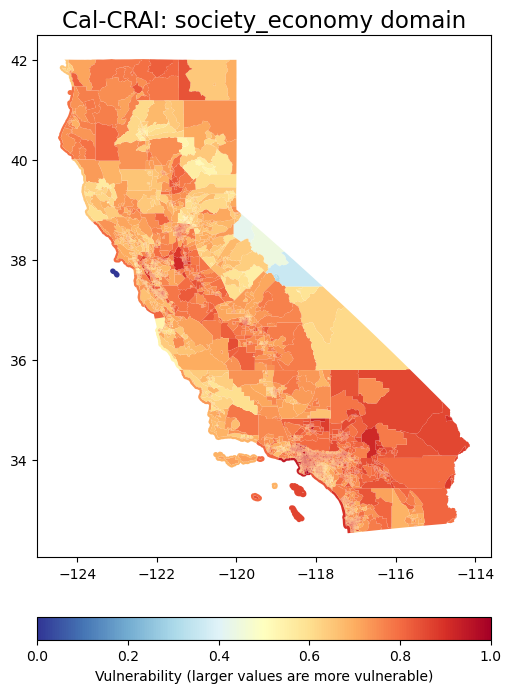

In [15]:
plot_domain(gdf, domain=domain_prefix)

We can also visualize specific areas! The following figure is an example of looking at Los Angeles and the surrounding counties. You can modify to any area of interest, just modify the county values (by the NFIP code). 
To do: optional function for folks to "look up" the NFIP code

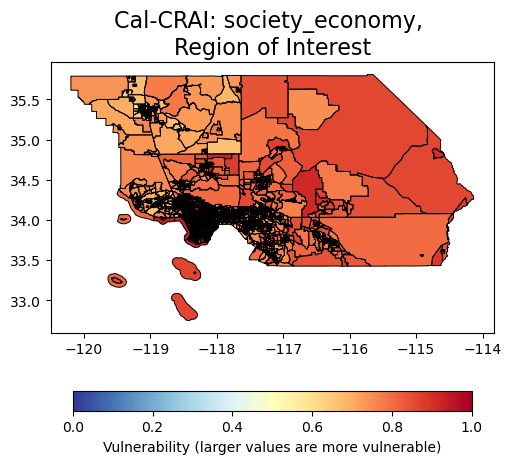

In [16]:
counties_to_viz = ['037', '071', '065', '029', '111'] # NFIP codes
plot_region_domain(gdf, counties_to_viz, domain=domain_prefix)

## Step 4: Export the final domain csv file

In [17]:
# set-up file for export
filename = '{}index_data.csv'.format(domain_prefix)
gdf.to_csv(filename, index=False)

# export to AWS (Cal-CRAI)
directory = '3_fair_data/domain_standardized_data'
upload_csv_aws([filename], bucket_name, directory)